<a href="https://colab.research.google.com/github/jaimeoconor/datakit-financial-inclusion-2025/blob/main/pix_financial_inclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix instant payments as a catalyst for Financial Inclusion in Brazil

The Central Bank of Brazil measures financial inclusion through an index based on four key pillars: access to financial services, financial education, consumer protection, and participation in the financial system. As of the latest data from 2020, this index showed a strong correlation with GDP: wealthier states tended to have higher levels of financial inclusion, while poorer regions lagged behind. This revealed a structural inequality in access to financial services across the country.




In the same year, Pix —Brazil’s free instant payment system— was launched. Unlike the financial inclusion index, Pix adoption quickly spread across all states, showing much less dependence on regional GDP levels and demonstrating its ability to reach populations traditionally underserved by the financial system.

By making digital transactions fast, free, and available 24/7, Pix has emerged as a transformative tool in promoting financial inclusion—especially in areas where traditional banking infrastructure is limited.



In [24]:
import pandas as pd
import requests
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


# Fetching data from IBGE and Central Bank



> Most of Brazil’s key economic and demographic data is provided by two main institutions: the IBGE (Brazilian Institute of Geography and Statistics) and the Central Bank of Brazil. Both offer well-structured APIs, making it easy to access and integrate their datasets. By using the municipality ID provided by IBGE, it's possible to seamlessly merge data from different sources at the local level.

> For this analysis, I retrieved GDP and population estimates by municipality from IBGE, and Pix transaction volume by municipality from the Central Bank of Brazil. These datasets serve as examples of the wide range of information that can be accessed through these sources.





In [14]:
#IBGE data

# List of API URLs
urls = [
    "https://servicodados.ibge.gov.br/api/v3/agregados/6579/periodos/-6/variaveis/9324?localidades=N6[all]",
    "https://servicodados.ibge.gov.br/api/v3/agregados/5938/periodos/-6/variaveis/37?localidades=N6[all]"
    # Add more URLs here if needed
    # "https://another.url/...",
]

# Headers
headers = {
    "Authorization": "add_your_keys_here"
}

# List to store all processed data
todas_series = []

for url in urls:
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        dados = response.json()

        # Extract variable name and unit from the first block
        variavel = dados[0]['variavel']
        unidade = dados[0]['unidade']

        for resultado in dados[0]['resultados']:
            for serie in resultado['series']:
                location_id = serie['localidade']['id']
                location_name = serie['localidade']['nome']

                for year, value in serie['serie'].items():
                    try:
                        value_int = int(value)
                        todas_series.append({
                            'variable': variavel,
                            'unit': unidade,
                            'AnoMes': int(year),
                            'Municipio_Ibge': location_id,
                            'Municipio': location_name,
                            'value': value_int
                        })
                    except ValueError:
                        continue   # skip invalid values like '...'
    else:
        print(f"Error accessing URL: : {url} (status {response.status_code})")

# Create final DataFrame
df_ibge = pd.DataFrame(todas_series)

# Order by location and variable
df_ibge = df_ibge.sort_values(['Municipio', 'variable'])

# Show df
df_ibge.head()

,variable,unit,AnoMes,Municipio_Ibge,Municipio,value
31938,População residente estimada,Pessoas,2017,5200050,Abadia de Goiás - GO,8207
31939,População residente estimada,Pessoas,2018,5200050,Abadia de Goiás - GO,8583
31940,População residente estimada,Pessoas,2019,5200050,Abadia de Goiás - GO,8773
31941,População residente estimada,Pessoas,2020,5200050,Abadia de Goiás - GO,8958
31942,População residente estimada,Pessoas,2021,5200050,Abadia de Goiás - GO,9158


In [15]:
#Filtering and joining 2021 data

df_population21 = df_ibge[(df_ibge['variable']=='População residente estimada') & (df_ibge['AnoMes']==2021)]

df_pbi21 = df_ibge[(df_ibge['variable']=='Produto Interno Bruto a preços correntes') & (df_ibge['AnoMes']==2021)]

df_ibge21 = df_ibge[df_ibge['AnoMes']==2021][['Municipio', 'Municipio_Ibge', 'variable', 'value']]

df_ibge21 = df_ibge21.pivot(index=['Municipio', 'Municipio_Ibge'], columns='variable', values='value').reset_index()

df_ibge21['pbi_per_capita'] = df_ibge21['Produto Interno Bruto a preços correntes']/df_ibge21['População residente estimada']

df_ibge21.sort_values(by='pbi_per_capita', ascending=False).head()


variable,Municipio,Municipio_Ibge,População residente estimada,Produto Interno Bruto a preços correntes,pbi_per_capita
1137,Catas Altas - MG,3115359,5465,5032358,920.834035
969,Canaã dos Carajás - PA,1502152,39103,34989610,894.806281
4810,São Gonçalo do Rio Abaixo - MG,3161908,11114,7603851,684.168706
2372,Itatiaiuçu - MG,3133709,11354,6934792,610.779637
3982,Presidente Kennedy - ES,3204302,11741,6811825,580.174176


In [16]:
# Central Bank data

url =  "https://olinda.bcb.gov.br/olinda/servico/Pix_DadosAbertos/versao/v1/odata/TransacoesPixPorMunicipio(DataBase=@DataBase)?@DataBase='202503'"

response = requests.get(url)

if response.status_code == 200:

    dados = response.json()
else:
    print(f"Erro ao acessar a API: {response.status_code}")

df = pd.DataFrame(dados['value'])

#Format column
df['Municipio_Ibge'] = df['Municipio_Ibge'].astype('Int64')

# Melt the df to standarize IBGE df structure
df_bcb = pd.melt(df, id_vars=['Municipio_Ibge', 'Municipio', 'AnoMes'],
                  value_vars=['VL_PagadorPF', 'QT_PagadorPF','QT_PES_PagadorPF'],
                  var_name='variable', value_name='value')

unit_map = {
    'VL_PagadorPF': 'Reais',
    'QT_PagadorPF': 'Pessoas',
    'QT_PES_PagadorPF': 'Pessoas'
}

df_bcb['unit'] = df_bcb['variable'].map(unit_map)

df_bcb = df_bcb[['variable', 'unit', 'AnoMes', 'Municipio_Ibge', 'Municipio', 'value']]
df_bcb.head()

,variable,unit,AnoMes,Municipio_Ibge,Municipio,value
0,VL_PagadorPF,Reais,202504,2106375,MARANHÃOZINHO,17540513.41
1,VL_PagadorPF,Reais,202503,5201207,ANHANGUERA,3274333.25
2,VL_PagadorPF,Reais,202503,2600401,ÁGUA PRETA,59940779.57
3,VL_PagadorPF,Reais,202503,5218706,RIANÁPOLIS,26830706.90
4,VL_PagadorPF,Reais,202504,3508207,BURITIZAL,10503561.17


In [17]:
#Getting latest data

df_bcb
df_bcb25 = df_bcb[df_bcb['AnoMes']==202503][['Municipio', 'Municipio_Ibge', 'variable', 'value']]

df_bcb25 = df_bcb25.pivot(index=['Municipio', 'Municipio_Ibge'], columns='variable', values='value').reset_index()
df_bcb25.head()

variable,Municipio,Municipio_Ibge,QT_PES_PagadorPF,QT_PagadorPF,VL_PagadorPF
0,ABADIA DE GOIÁS,5200050,8035.0,336866.0,5.685413e+07
1,ABADIA DOS DOURADOS,3100104,3111.0,73213.0,2.208958e+07
2,ABADIÂNIA,5200100,7999.0,280962.0,5.604838e+07
3,ABAETETUBA,1500107,89665.0,3357914.0,4.944936e+08
4,ABAETÉ,3100203,13005.0,408508.0,7.765186e+07


In [18]:
# Adding Financial Inclusion Index data

data = {
    'estado': [
        'Distrito Federal', 'São Paulo', 'Santa Catarina', 'Rio de Janeiro',
        'Mato Grosso do Sul', 'Rio Grande do Sul', 'Paraná', 'Espírito Santo',
        'Mato Grosso', 'Minas Gerais', 'Goiás', 'Sergipe', 'Rio Grande do Norte',
        'Roraima', 'Paraíba', 'Piauí', 'Bahia', 'Ceará', 'Tocantins', 'Pernambuco',
        'Alagoas', 'Rondônia', 'Acre', 'Maranhão', 'Amapá', 'Amazonas', 'Pará', 'Brasil'
    ],
    'indice_cid_financeira': [
        75.6, 69.9, 60.4, 58.7, 56.5, 56.4, 55.6, 54.8,
        53.6, 53.3, 51.6, 46.6, 41.1, 40.6, 39.8, 39.1,
        37.0, 35.7, 35.1, 33.1, 32.9, 27.7, 22.0, 18.8,
        16.2, 15.7, 15.5, 45.1
    ]
}

# Mapping of state names to their UFs
estado_to_uf = {
    'Acre': 'AC',
    'Alagoas': 'AL',
    'Amapá': 'AP',
    'Amazonas': 'AM',
    'Bahia': 'BA',
    'Ceará': 'CE',
    'Distrito Federal': 'DF',
    'Espírito Santo': 'ES',
    'Goiás': 'GO',
    'Maranhão': 'MA',
    'Mato Grosso': 'MT',
    'Mato Grosso do Sul': 'MS',
    'Minas Gerais': 'MG',
    'Pará': 'PA',
    'Paraíba': 'PB',
    'Paraná': 'PR',
    'Pernambuco': 'PE',
    'Piauí': 'PI',
    'Rio de Janeiro': 'RJ',
    'Rio Grande do Norte': 'RN',
    'Rio Grande do Sul': 'RS',
    'Rondônia': 'RO',
    'Roraima': 'RR',
    'Santa Catarina': 'SC',
    'São Paulo': 'SP',
    'Sergipe': 'SE',
    'Tocantins': 'TO',
    'Brasil': None  # or 'BR' if you prefer
}

df_indice_cid_fin20 = pd.DataFrame(data)
df_indice_cid_fin20['uf'] = df_indice_cid_fin20['estado'].map(estado_to_uf)

df_indice_cid_fin20.head()

,estado,indice_cid_financeira,uf
0,Distrito Federal,75.6,DF
1,São Paulo,69.9,SP
2,Santa Catarina,60.4,SC
3,Rio de Janeiro,58.7,RJ
4,Mato Grosso do Sul,56.5,MS


In [19]:
# Merging datasets

df_ibge21['Municipio_Ibge'] = df_ibge21['Municipio_Ibge'].astype(str)
df_bcb25['Municipio_Ibge'] = df_bcb25['Municipio_Ibge'].astype(str)
df_merged = pd.merge(df_ibge21, df_bcb25, on='Municipio_Ibge', how='inner')
df_merged['state'] = df_merged['Municipio_x'].str[-2:]
df_merged['pix_users_perc'] = df_merged['QT_PES_PagadorPF']/df_merged['População residente estimada']

df_merged.head()

variable,Municipio_x,Municipio_Ibge,População residente estimada,Produto Interno Bruto a preços correntes,pbi_per_capita,Municipio_y,QT_PES_PagadorPF,QT_PagadorPF,VL_PagadorPF,state,pix_users_perc
0,Abadia de Goiás - GO,5200050,9158,353700,38.621970,ABADIA DE GOIÁS,8035.0,336866.0,5.685413e+07,GO,0.877375
1,Abadia dos Dourados - MG,3100104,7022,176774,25.174309,ABADIA DOS DOURADOS,3111.0,73213.0,2.208958e+07,MG,0.443036
2,Abadiânia - GO,5200100,20873,445324,21.334930,ABADIÂNIA,7999.0,280962.0,5.604838e+07,GO,0.383222
3,Abaetetuba - PA,1500107,160439,1949341,12.150045,ABAETETUBA,89665.0,3357914.0,4.944936e+08,PA,0.558873
4,Abaeté - MG,3100203,23263,541239,23.266088,ABAETÉ,13005.0,408508.0,7.765186e+07,MG,0.559042


In [20]:
# Grouping by State

df_grouped = df_merged.groupby('state')[['População residente estimada', 'Produto Interno Bruto a preços correntes', 'QT_PES_PagadorPF', 'QT_PagadorPF', 'VL_PagadorPF']].sum().reset_index()
df_grouped['pix_users_perc'] = df_grouped['QT_PES_PagadorPF']/df_grouped['População residente estimada']
df_grouped['pbi_per_capita'] = df_grouped['Produto Interno Bruto a preços correntes']/df_grouped['População residente estimada']
df_grouped = pd.merge(df_grouped, df_indice_cid_fin20, left_on='state', right_on='uf', how='left')

df_grouped.sort_values(by='pix_users_perc', ascending=False).head()


,state,População residente estimada,Produto Interno Bruto a preços correntes,QT_PES_PagadorPF,QT_PagadorPF,VL_PagadorPF,pix_users_perc,pbi_per_capita,estado,indice_cid_financeira,uf
21,RR,652713,18202580,570482.0,2.402793e+07,3.426425e+09,0.874017,27.887571,Roraima,40.6,RR
6,DF,3094325,286943782,2278934.0,8.146483e+07,1.838642e+10,0.736488,92.732270,Distrito Federal,75.6,DF
25,SP,46649132,2719751234,32266114.0,1.038567e+09,2.217201e+11,0.691677,58.302290,São Paulo,69.9,SP
12,MT,3567234,233390206,2381979.0,8.833375e+07,2.333903e+10,0.667738,65.426099,Mato Grosso,53.6,MT
18,RJ,17463349,949300764,11620364.0,4.368048e+08,7.138371e+10,0.665414,54.359606,Rio de Janeiro,58.7,RJ


# Correlation between GDP per capita, Financial Inclusion Index and Instant Payments adoption


> The following charts illustrate the correlation between GDP and the Financial Inclusion Index, as well as between GDP and Pix adoption across Brazilian municipalities. As shown, financial inclusion is strongly correlated with GDP, with an R² value of 0.79—indicating that wealthier regions tend to have significantly higher levels of financial inclusion. In contrast, the correlation between GDP and Pix adoption is notably weaker, with an R² of 0.51.

This suggests that while traditional financial inclusion remains closely tied to regional economic conditions, Pix adoption is more evenly distributed.




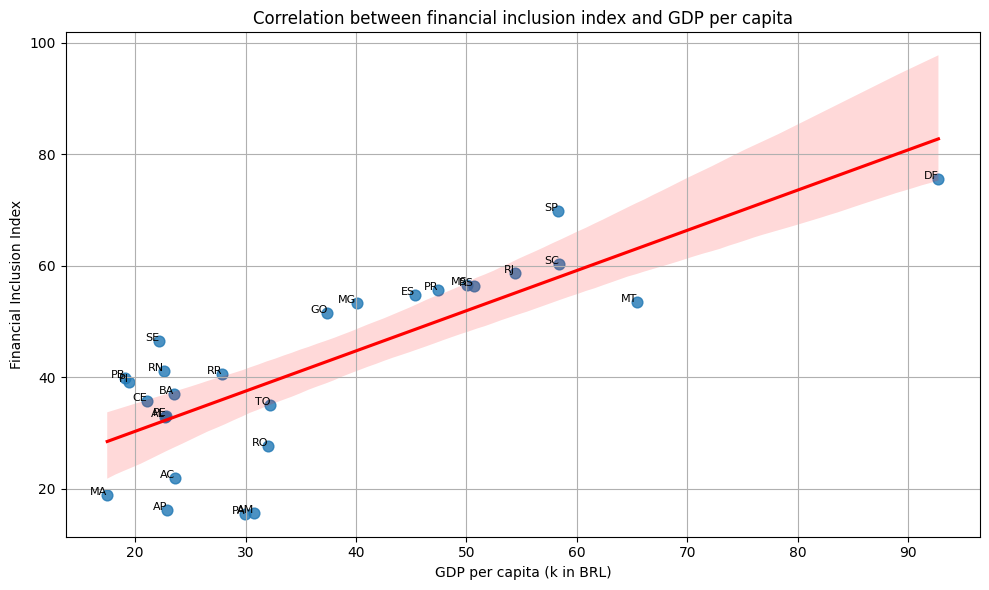

Correlation (r): 0.789
p-value: 0.0000


In [21]:
#Correlation between financial inclusion index and GDP per capita

plt.figure(figsize=(10, 6))
sns.regplot(x='pbi_per_capita', y='indice_cid_financeira', data=df_grouped, scatter_kws={'s': 60}, line_kws={'color': 'red'})

# Add state labels
for i, row in df_grouped.iterrows():
    plt.text(row['pbi_per_capita'], row['indice_cid_financeira'], row['uf'], fontsize=8, ha='right')

plt.title('Correlation between financial inclusion index and GDP per capita')
plt.xlabel('GDP per capita (k in BRL)')
plt.ylabel('Financial Inclusion Index')
plt.grid(True)
plt.tight_layout()
plt.show()

r, p_value = pearsonr(df_grouped['pbi_per_capita'], df_grouped['indice_cid_financeira'])

print(f"Correlation (r): {r:.3f}")
print(f"p-value: {p_value:.4f}")

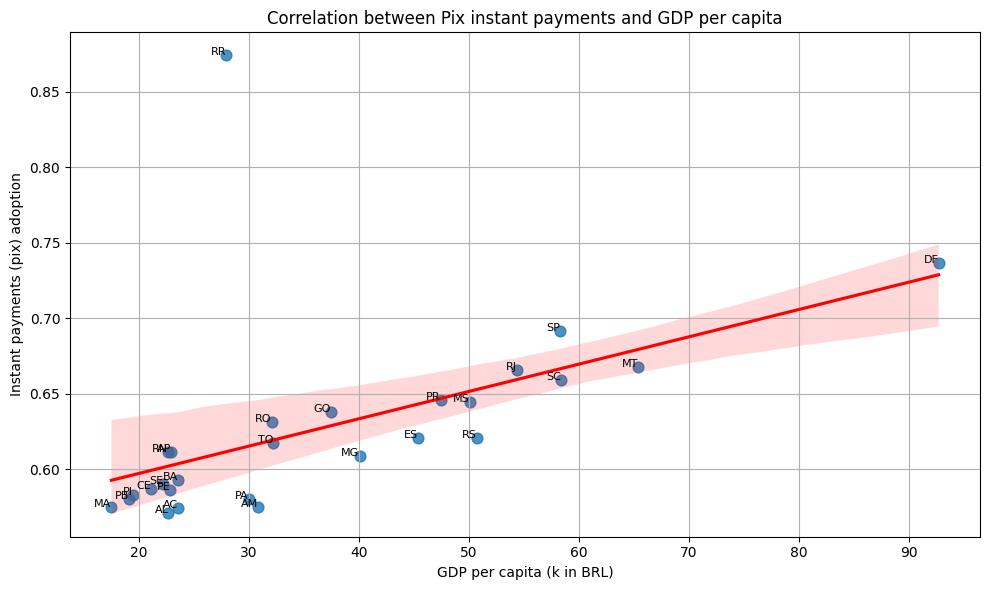

Correlation (r): 0.512
p-value: 0.0063


In [27]:
#Correlation between instant payments (pix) and GDP per capita


plt.figure(figsize=(10, 6))
sns.regplot(x='pbi_per_capita', y='pix_users_perc', data=df_grouped, scatter_kws={'s': 60}, line_kws={'color': 'red'})

# Add state labels
for i, row in df_grouped.iterrows():
    plt.text(row['pbi_per_capita'], row['pix_users_perc'], row['uf'], fontsize=8, ha='right')

plt.title('Correlation between Pix instant payments and GDP per capita')
plt.xlabel('GDP per capita (k in BRL)')
plt.ylabel('Instant payments (pix) adoption')
plt.grid(True)
plt.tight_layout()
plt.show()

r, p_value = pearsonr(df_grouped['pix_users_perc'], df_grouped['pbi_per_capita'])

print(f"Correlation (r): {r:.3f}")
print(f"p-value: {p_value:.4f}")

# GDP per capita and Instant Payments adoption distribution by municipality



> The following two maps present GDP per capita and Pix adoption by municipality. As historically observed, higher GDP per capita is concentrated in the Southeast, South, and Central-West regions. In contrast, Pix adoption is much more evenly distributed across the country, with significant uptake even in municipalities in the North and Northeast—regions that traditionally lag behind in economic indicators.



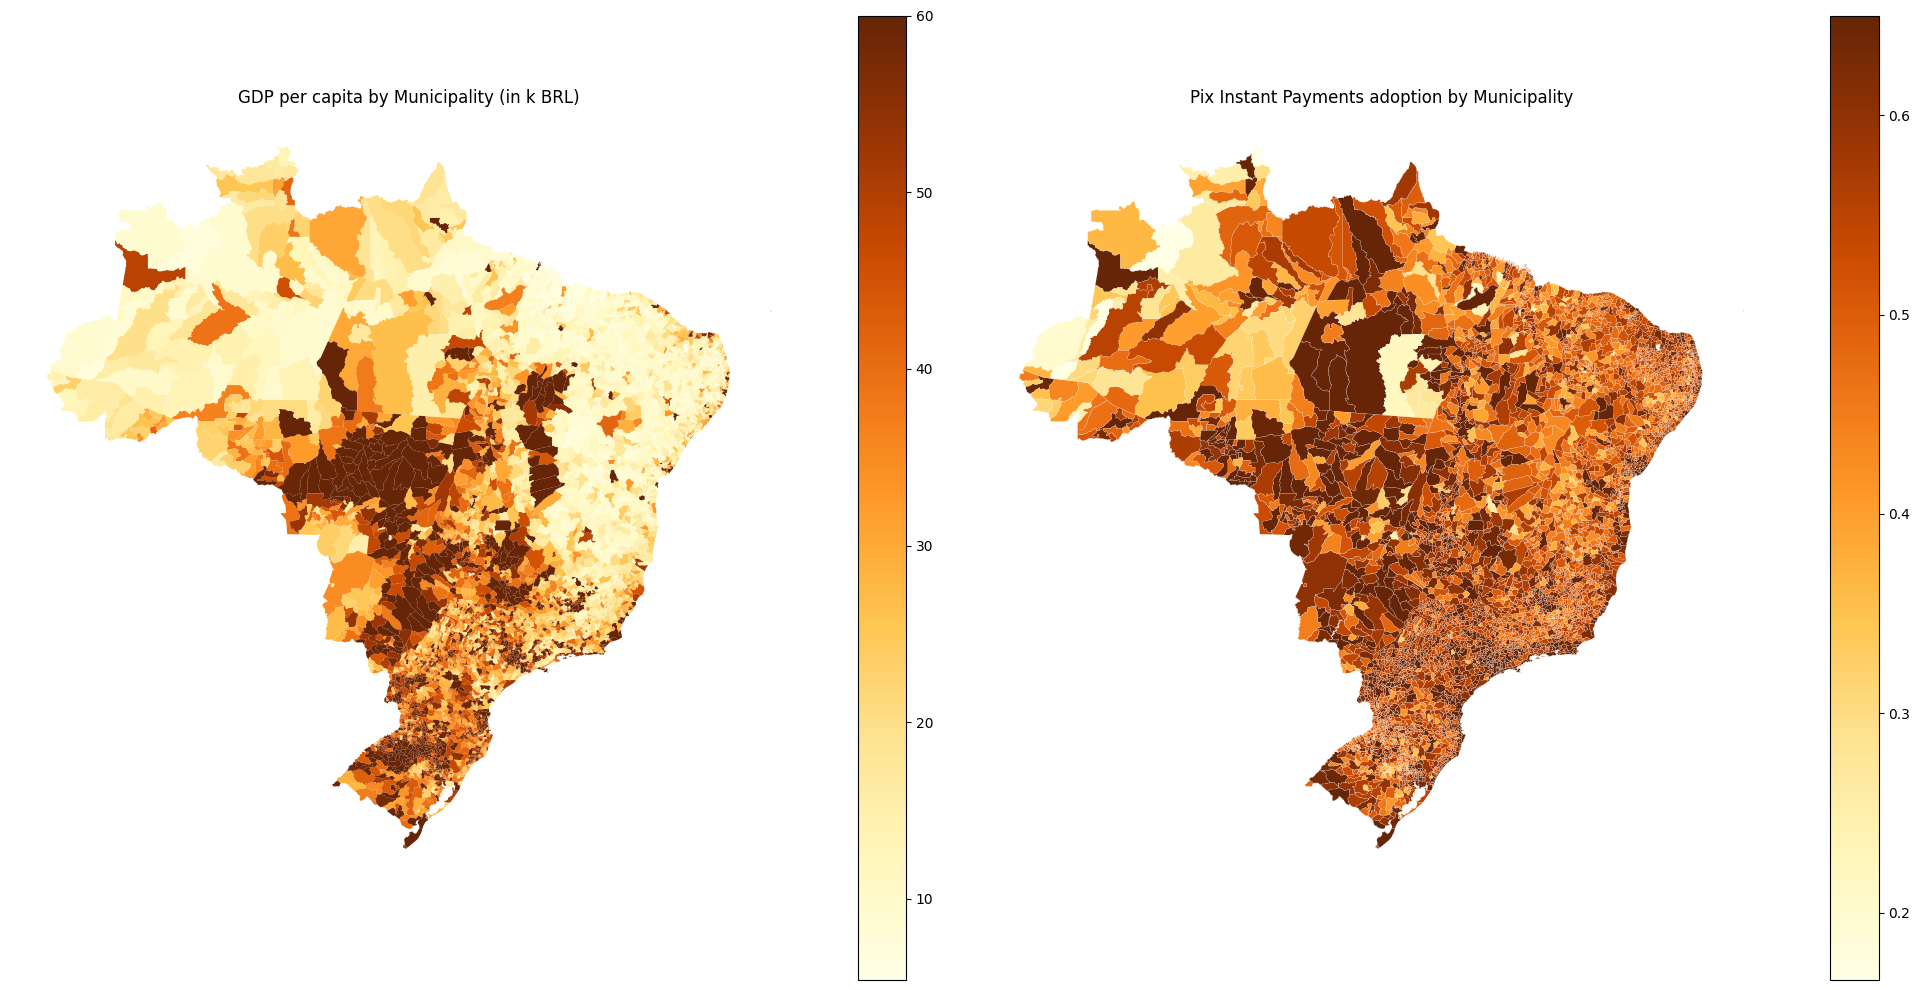

In [26]:

# Load GeoJSON from a public URL or local file
geo_muni = gpd.read_file("https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json")


merged = geo_muni.merge(df_merged, left_on='id', right_on='Municipio_Ibge', how='left')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# First map
merged.plot(
    column='pbi_per_capita',
    cmap='YlOrBr',
    linewidth=0.1,
    legend=True,
    vmax=60,
    ax=ax1
)
ax1.set_title('GDP per capita by Municipality (in k BRL)')
ax1.axis('off')

# Second map
merged.plot(
    column='pix_users_perc',
    cmap='YlOrBr',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    vmax=0.65,
    ax=ax2
)
ax2.set_title('Pix Instant Payments adoption by Municipality')
ax2.axis('off')

plt.tight_layout()
plt.show()